In [1]:
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style>') 

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from local_dotplot_lib import *

trna= "GCCUUUUUAGCUCAGUGGUAGAGCAUUGUAUUUUUGUAAUGCGGUGGUCGUCGGUUCGAAUCCGACAAAAGGCU"
trna2="GGGCUAUUAGCUCAGUUGGUUAGAGCGCACCCCUGAUAAGGGUGAGGUCGCUGAUUCGAAUUCAGCAUAGCCCA"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
np.set_printoptions(suppress=True,precision=3)
bpmat = getBPPM('GCGUGCUGCGC')
print bpmat

[[ 0.     0.     0.     0.     0.     0.     0.     0.     0.106  0.     0.855]
 [ 0.     0.     0.     0.     0.     0.     0.     0.106  0.     0.875  0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.04   0.     0.873  0.     0.002]
 [ 0.     0.     0.     0.     0.     0.     0.     0.764  0.     0.002  0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.002  0.     0.001]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.001  0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]]


In [263]:
def walk_basepairs_get_stems(mat, p_thresh=0.5, inner_loop=False):
    bpXs, bpYs = np.where(mat > p_thresh) # Note: hopefully the returned  indices of where are sorted by x values
    bpXs +=1
    bpYs += 1 
    if len(bpXs) == 0:
        #print ("WARNING: No basepair with prob larger than {}".format(p_thresh))
        return {}
        
    # startX: 3'end startY:5'end of the stem
    stem_startX, stem_startY = bpXs[0], bpYs[0]
    stem_endX, stem_endY = bpXs[0], bpYs[0]
    stems_dict = {} 
    stems_list = []
    for x, y in zip(bpXs, bpYs):
        #print '  {}-{},{}-{}'.format(stem_startX,stem_endX, stem_endY, stem_startY)

        #print x,y,
        if ( abs(x-stem_endX) <= 5 and abs(y-stem_endY) <= 5 and
               ((~inner_loop and ( (abs(x-stem_endX) <= 1) or (abs(y-stem_endY) <= 1)))
                or 
                (inner_loop  and ( (abs(x-stem_endX) <= 3) or (abs(y-stem_endY) <= 3)))
               )
               ):
        
            
#             if (abs(x-stem_endX) >= 5) or (abs(y-stem_endY) >= 5):
#                 print "WARNING: bulge of size larger than 5 added at x={}, y={}! ".format(x,y)
                
            stem_endX = x
            stem_endY = y
        else:
            #print " new",
            #print '  {}-{},{}-{}'.format(stem_startX,stem_endX, stem_endY, stem_startY)
            # Validating order of stem indices
            
            assert stem_startX <= stem_endX
            assert stem_endX < stem_endY
            assert stem_endY <= stem_startY
            
            # stem coords as key string
            k = '{}-{},{}-{}'.format(stem_startX,stem_endX, stem_endY, stem_startY)
            # stem length as dict value
            stems_dict[k] = max( (stem_endX-stem_startX) , (stem_startY-stem_endY)), stem_endY-stem_endX
            
            stem_startX, stem_startY = x, y
            stem_endX, stem_endY = x, y
    
    k = '{}-{},{}-{}'.format(stem_startX,stem_endX, stem_endY, stem_startY)
    #print k, stem_endX-stem_startX , (stem_startY-stem_endY)
    assert k not in stems_dict # It should be the case always..?
    stems_dict[k] = max( (stem_endX-stem_startX+1) , (stem_startY-stem_endY+1)), stem_endY-stem_endX 
    
    return stems_dict
    
walk_basepairs_get_stems(bpmat,inner_loop=True)
# bpXs, bpYs = np.where(bpmat>0.5)
# zip(bpXs, bpYs, bpXs+1, bpYs+1)


{'1-4,8-11': (4, 4)}

In [261]:
import pandas as pd
def fasta_to_df(fasta_file, add_shuffle=True,add_bpmat=True):
    seq_recs = list(SeqIO.parse(fasta_file, format='fasta'))
    df_fasta = pd.DataFrame(index=[r.id for r in seq_recs])

    df_fasta['sequence'] = [str(s.seq).replace('T','U').replace('t','u') for s in seq_recs] 
    if add_shuffle:
        df_fasta['sequence-shuffled'] = [dinuclShuffle(s.upper().replace('T','U')) for s in df_fasta['sequence']]
    if add_bpmat:
        df_fasta['bp-matrix'] = [getBPPM(s) for s in df_fasta['sequence']]
        if add_shuffle:
            df_fasta['bp-matrix-shuffled'] = [getBPPM(s) for s in df_fasta['sequence-shuffled']]
    return df_fasta
fasta_phast20 = '/home/milad/1workspace/GalaxyGraphClust/Staufen/commonfold/stau-phastcons0.2-mergedoverlaps-Galaxy1-[Extract_Genomic_DNA_on_data_1].fasta'
mydf = fasta_to_df(fasta_phast20)
mydf

KeyboardInterrupt: 

In [290]:
import numpy as np
def annotate_stems(df, rangeA = (45,55), rangeB = (73,83), ax=None):
    stems_nonfilt = [walk_basepairs_get_stems(s) for s in df['bp-matrix']]
    stems = filter_stemsd_list(stems_nonfilt)

    filter_stemsd_list
    stemA, stemB = [None]*len(df),[None]*len(df)
    inAarr, inBarr = [False]*len(df),[False]*len(df)
    for ids, sdic in enumerate(stems):
        keys = [k for k in sdic]
        centers = [int(re.split("\D+", k)[1]) + (int(re.split("\D+", k)[2]) - int(re.split("\D+", k)[1]))/2 for k in keys]
        diffs = [int(re.split("\D+", k)[2]) -int(re.split("\D+", k)[1]) for k in keys]
        isinA = [rangeA[0]<=c<=rangeA[1] for c in centers ]
        isinB = [rangeB[0]<=c<=rangeB[1] for c in centers ]
        if  True in isinA:
            if isinA.count(True)>1:
                print "Multiple centersA", [k for i,k in enumerate(keys) if isinA[i]]
            inAarr[ids] = True
            mindif = min([d for i,d in enumerate(diffs) if isinA[i]])
            stemA[ids] = keys[diffs.index(mindif)]
            
                              
        if True is isinB:
            if isinB.count(True)>1:
                print "Multiple centersB", [k for i,k in enumerate(keys) if isinB[i]]
            inBarr[ids] = True
            mindif = min([d for i,d in enumerate(diffs) if isinB[i]])
            stemB[ids] = keys[diffs.index(mindif)]
        
    df['stem-inA'] = stemA
    df['stem-inB'] = stemB
    
    return df
    
annotate_stems(mydf,rangeA=(23,33)) 

,sequence,sequence-shuffled,bp-matrix,bp-matrix-shuffled,stem-inA,stem-inB
hg19_chr1_1716749_1716849_-,ACCCCUUUCCACCUUUUGUAUUUAAUUUUAAAGUCAGUGUACUGCA...,AGUAAGGAAUGUUUAGUUUUAUAUUGUGCCCUGCAGAGCAAAGACC...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 7.67560029818e-05, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",None,None
hg19_chr1_1716865_1716965_-,UCUAUACAAAACUGUGCUGUGACCUUGCGGUAGGCCUGGAUCUGGC...,UAGACUCCUCUAAAAACCAAUUGCCUCAAACUUACCUCUGUGCUGU...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 3.82628253864e-05, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",None,None
hg19_chr1_1717611_1717711_-,UUUUAAUCUCACUUUGGGUUUCCUUGUGAAGUUGGAGGGAAGUUUA...,UCAAUCCAACCACCCUUUGAAACCUACCACUUUUCCUACUAAGAGU...,"[[0.0, 0.0, 0.0, 0.0, 0.000106145246125, 0.000...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.4023970...",None,None
hg19_chr1_1718363_1718463_-,AUUCCAACUUGGACGCGUUACCAUGAGAGCAUAUCCUAUCCAACCG...,AAUAACAGACACAAGAAUUGCAAUUAGCACUCUAUCUCCCAGGAAA...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.78...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",None,None
hg19_chr1_2238712_2238812_+,UUUUCAGCGACAAGGACCCAGGUCUUCCUGCUGCUGCCAGGGAGAG...,UUUUUGCUGAGACCCUCAGCGGGCAGACUCAGGGCAGUCUGUGCCU...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 7.94904748008e-05, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 8.41194842087e-07, ...",None,None
hg19_chr1_2239898_2239998_+,UCUUUGCGGUUGUUCUGUGUGCAUGGAUUCCACACCUCUGCCGUAG...,UGUACGGUCGUACUCCUCCCAUGUUUUAGUUGCUAUUUUCAGGUUG...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 4.27928768601e-06, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 4.42331296861e-07, ...",None,None
hg19_chr1_2240778_2240878_+,UUUUAACGAAGGGAAAAACAACAGCAAUAACAUUCAUAUCUCUGGA...,UACACAUAAAGACAUAACUGUCUCAAAGCAAAUGGGCUUACCGAGU...,"[[0.0, 0.0, 0.0, 0.0, 7.17594364087e-05, 6.031...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.000180697471994, ...",None,None
hg19_chr1_2241343_2241443_+,CGUUCUCGCUUUAAGUCAGGAGUCACAAAUGACUUUUUUUUUUCAA...,CCAUAACCACUUUUUUCAUAAUUCGAACCAAGGCCAAAAGGCUCCG...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0547803...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","21-25,30-34",None
hg19_chr1_8414369_8414469_-,uuauCCCUUUAAUUAAAGGGAGCAAAGGGGCGUUCCACAUGGACAG...,UCCAGGAAAGCCGGACGAGAGGAAACAGUUCGCAUCUACAGGCAUC...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 5.67366995151e-06, 1.825...",None,None
hg19_chr1_8414748_8414848_-,UUUCCUUGAUUUCUCAGUAGGUGCUAGAAUCCAGUUCACACCCUUC...,UCAUCAAGUGUCACUGCUCCUUCGUUCACCUCACUACCAGCACAUG...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0004321...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.000107526833909, ...",None,None


In [291]:
mydf

,sequence,sequence-shuffled,bp-matrix,bp-matrix-shuffled,stem-inA,stem-inB
hg19_chr1_1716749_1716849_-,ACCCCUUUCCACCUUUUGUAUUUAAUUUUAAAGUCAGUGUACUGCA...,AGUAAGGAAUGUUUAGUUUUAUAUUGUGCCCUGCAGAGCAAAGACC...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 7.67560029818e-05, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",None,None
hg19_chr1_1716865_1716965_-,UCUAUACAAAACUGUGCUGUGACCUUGCGGUAGGCCUGGAUCUGGC...,UAGACUCCUCUAAAAACCAAUUGCCUCAAACUUACCUCUGUGCUGU...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 3.82628253864e-05, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",None,None
hg19_chr1_1717611_1717711_-,UUUUAAUCUCACUUUGGGUUUCCUUGUGAAGUUGGAGGGAAGUUUA...,UCAAUCCAACCACCCUUUGAAACCUACCACUUUUCCUACUAAGAGU...,"[[0.0, 0.0, 0.0, 0.0, 0.000106145246125, 0.000...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.4023970...",None,None
hg19_chr1_1718363_1718463_-,AUUCCAACUUGGACGCGUUACCAUGAGAGCAUAUCCUAUCCAACCG...,AAUAACAGACACAAGAAUUGCAAUUAGCACUCUAUCUCCCAGGAAA...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.78...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",None,None
hg19_chr1_2238712_2238812_+,UUUUCAGCGACAAGGACCCAGGUCUUCCUGCUGCUGCCAGGGAGAG...,UUUUUGCUGAGACCCUCAGCGGGCAGACUCAGGGCAGUCUGUGCCU...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 7.94904748008e-05, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 8.41194842087e-07, ...",None,None
hg19_chr1_2239898_2239998_+,UCUUUGCGGUUGUUCUGUGUGCAUGGAUUCCACACCUCUGCCGUAG...,UGUACGGUCGUACUCCUCCCAUGUUUUAGUUGCUAUUUUCAGGUUG...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 4.27928768601e-06, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 4.42331296861e-07, ...",None,None
hg19_chr1_2240778_2240878_+,UUUUAACGAAGGGAAAAACAACAGCAAUAACAUUCAUAUCUCUGGA...,UACACAUAAAGACAUAACUGUCUCAAAGCAAAUGGGCUUACCGAGU...,"[[0.0, 0.0, 0.0, 0.0, 7.17594364087e-05, 6.031...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.000180697471994, ...",None,None
hg19_chr1_2241343_2241443_+,CGUUCUCGCUUUAAGUCAGGAGUCACAAAUGACUUUUUUUUUUCAA...,CCAUAACCACUUUUUUCAUAAUUCGAACCAAGGCCAAAAGGCUCCG...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0547803...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","21-25,30-34",None
hg19_chr1_8414369_8414469_-,uuauCCCUUUAAUUAAAGGGAGCAAAGGGGCGUUCCACAUGGACAG...,UCCAGGAAAGCCGGACGAGAGGAAACAGUUCGCAUCUACAGGCAUC...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 5.67366995151e-06, 1.825...",None,None
hg19_chr1_8414748_8414848_-,UUUCCUUGAUUUCUCAGUAGGUGCUAGAAUCCAGUUCACACCCUUC...,UCAUCAAGUGUCACUGCUCCUUCGUUCACCUCACUACCAGCACAUG...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0004321...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.000107526833909, ...",None,None


In [310]:
# def extract_stem_seqs(df):
# mydf[mydf['stem-inA'].notnull()]
# df_A = mydf[mydf['stem-inA'].notnull()]
df_A.head()['sequence'].str.slice(df_A.head()['stem-inA'].str.split('-').str[0].astype(int), df_A.head()['stem-inA'].str.split('-').str[2].astype(int))

hg19_chr1_2241343_2241443_+     NaN
hg19_chr1_8415038_8415138_-     NaN
hg19_chr1_26607887_26607987_+   NaN
hg19_chr1_27733409_27733509_-   NaN
hg19_chr1_28826526_28826626_+   NaN
Name: sequence, dtype: float64

In [277]:
[True] * 2

[True, True]

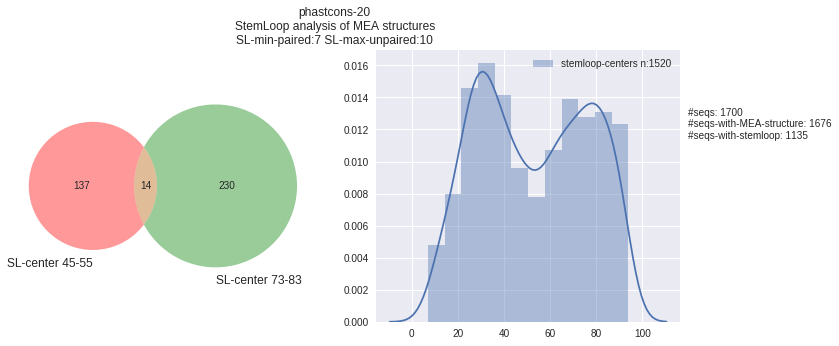

In [253]:
%matplotlib inline
from matplotlib import pyplot as plt
import re
import seaborn as sns

def filter_stemsd_list(sdl, max_inner_distance=10, min_stem_length=4):
    sdl_filt = list()
    for sd in sdl:
        #print sd
        sd_filt ={k:sd[k] for k in sd if sd[k][0]>=min_stem_length and sd[k][1]<=max_inner_distance}
        #print sd_filt
        #print
        sdl_filt.append(sd_filt)
    return sdl_filt

from matplotlib_venn import venn2#, venn3_circles
def plot_venn(stems, rangeA = (45,55), rangeB = (73,83), ax=None):
    setinA, setinB = set(), set()

    for ids, sdic in enumerate(stems):
        centers = [int(re.split("\D+", k)[1]) + (int(re.split("\D+", k)[2]) - int(re.split("\D+", k)[1]))/2 for k in sdic]
        inA = 0 < len([c for c in centers if rangeA[0]<=c<=rangeA[1]])
        inB = 0 < len([c for c in centers if rangeB[0]<=c<=rangeB[1]])
        if inA:
            setinA.add(ids)
        if inB:
            setinB.add(ids)
        
    venn2([setinA, setinB], set_labels =['SL-center {}-{}'.format(*rangeA),'SL-center {}-{}'.format(*rangeB)],ax=ax)
    
def plot_stems_loc(stemdl_nonfilt, title='',filt=False, max_inner_distance=10, min_stem_length=7, venn=True):
    if filt is True:
        stemdl = filter_stemsd_list(stemdl_nonfilt)
    else:
        stemdl = stemdl_nonfilt
    fig, axes = plt.subplots(ncols=2,figsize=(12,5))
    #starts = [ int(re.split("\D+", k)[1]) for sd in stemdl for k in sd  if len(sd)>0 ]
    #sns.distplot(starts, ax=ax,label='starts')
    #ends = [ int(re.split("\D+", k)[2]) for sd in stemdl for k in sd  if len(sd)>0 ]
    #sns.distplot(ends,ax=ax,label='ends')
    
    centers = [ int(re.split("\D+", k)[1]) + (int(re.split("\D+", k)[2]) - int(re.split("\D+", k)[1]))/2 for sd in stemdl for k in sd  if len(sd)>0 ]
    #print centers
    sns.distplot(centers,ax=axes[1],label='stemloop-centers n:{}'.format(len(centers)))
    axes[1].legend()
    axes[1].text(x = 120, y=0.01, s='#seqs: {}\n#seqs-with-MEA-structure: {}\n#seqs-with-stemloop: {}\n\n     '.format(len(stemdl_nonfilt), 
                                                                                  len([sd for sd in stemdl_nonfilt if len(sd)>0]),
                                                                                  len([sd for sd in stemdl if len(sd)>0]),
                                                                                   
                                                                                                                          ),
            horizontalalignment='left',
                )
    if venn is True:
        plot_venn(stemdl,ax=axes[0])
    fig.suptitle(title + '\nStemLoop analysis of MEA structures\n' +   'SL-min-paired:{} SL-max-unpaired:{}'.format(min_stem_length,max_inner_distance)
                , y=1.0)
stems = [walk_basepairs_get_stems(s) for s in mydf['bp-matrix']]
# plot_stems_loc(stems)
# plot_stems_loc(stems,filt=False)
plot_stems_loc(stems,title='phastcons-20',filt=True)


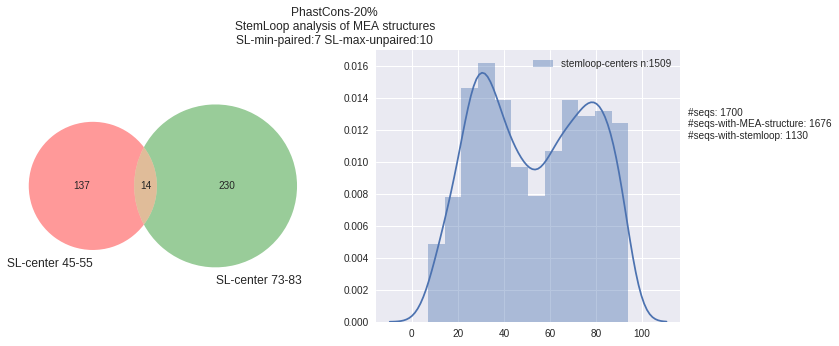

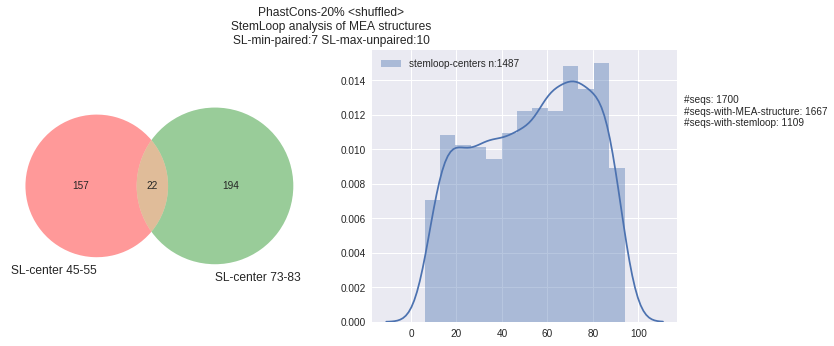

In [274]:
def analyze_df(df, filename,title='',average=True, walk_stems=True, venn=True, filt=False):
    if average:
        average_bpmat = np.average(df['bp-matrix'])
        average_bpmat_shuff = np.average(df['bp-matrix-shuffled'])
        fig_file = filename.replace('fasta','fa').replace('.fa','.shuffled.dp')
        fig_file_shuff = filename.replace('fasta','fa').replace('.fa','.dp')
        plot_heat_maps(None, average_bpmat, filename=fig_file, what='basepairs',
                   inverse=True, interactive=False, gene_loc=None)
        plot_heat_maps(None, average_bpmat_shuff, filename=fig_file_shuff, what='basepairs',
                   inverse=True, interactive=False, gene_loc=None)
        
    if walk_stems:
        stems = [walk_basepairs_get_stems(s) for s in df['bp-matrix']]
        plot_stems_loc(stems,venn=venn, filt=filt,title=title)
        plt.show()
        stems_shuf = [walk_basepairs_get_stems(s) for s in df['bp-matrix-shuffled']]
        plot_stems_loc(stems_shuf,venn=venn,filt=filt,title=title+' <shuffled>')
        plt.show()
    
# analyze_df(mydf, fasta_phast20, average=False,walk_stems=True)
analyze_df(mydf, fasta_phast20, 'PhastCons-20%',average=False,walk_stems=True,filt=True)

In [119]:
mydf_peakcentered = fasta_to_df('../../GalaxyGraphClust/Staufen/Galaxy7-[stau-extended100-fixed-centered.fa].fasta')


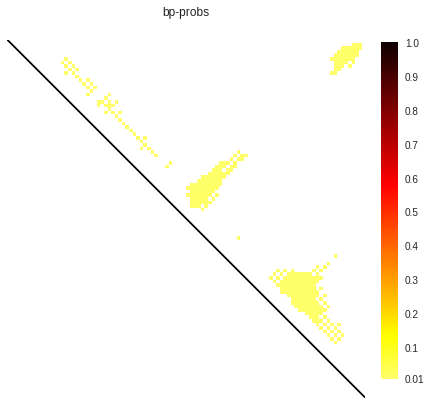

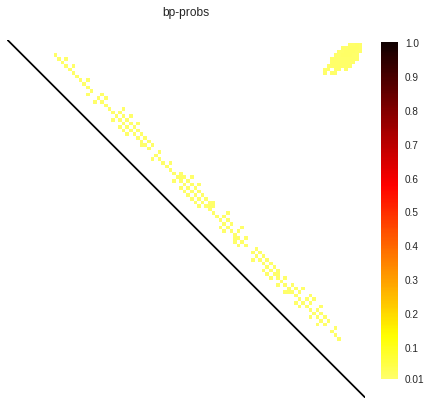

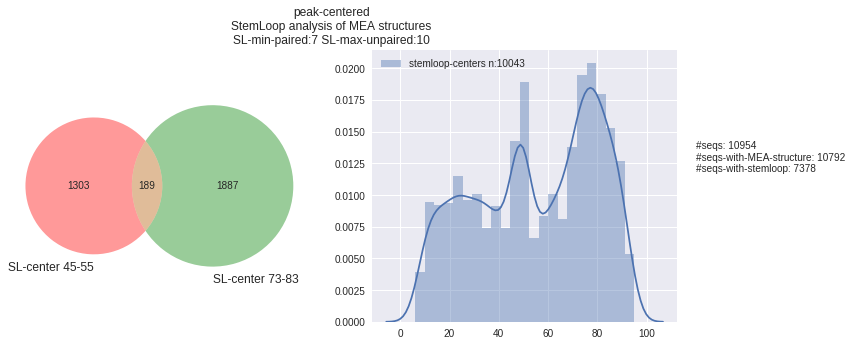

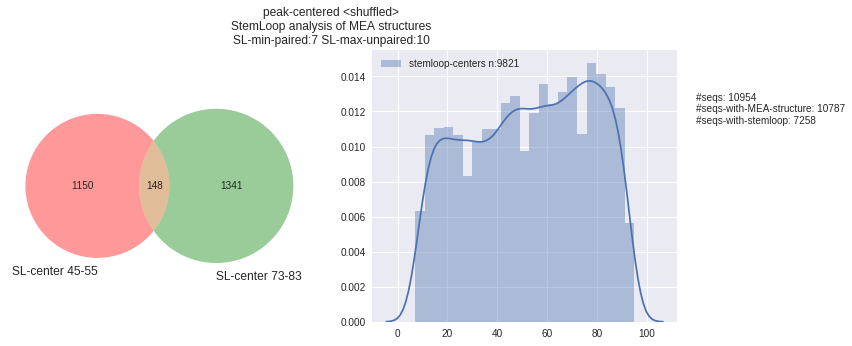

In [275]:
analyze_df(mydf_peakcentered,'stau-extended100-fixed-centered.fa',title='peak-centered',filt=True)

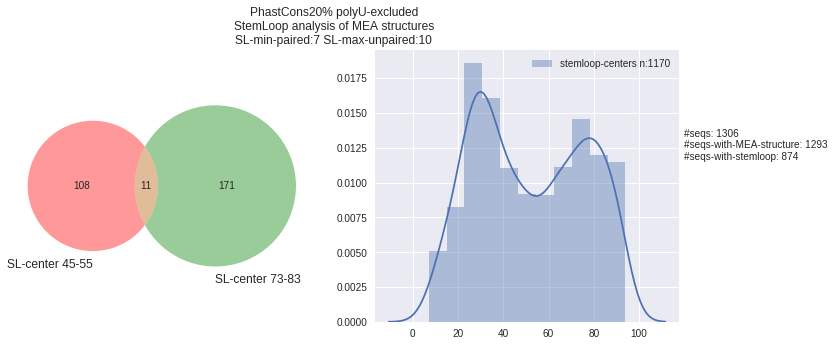

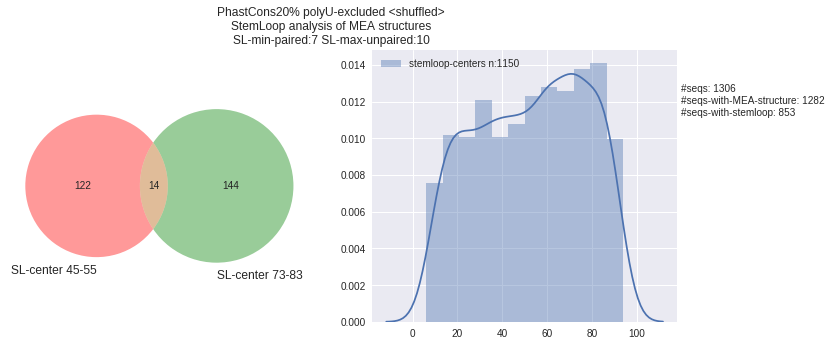

In [276]:
# analyze_df(mydf[mydf['sequence'].str[:20].str.upper().str.count('U')<10]
#            , fasta_phast20, average=False,walk_stems=True)
analyze_df(mydf[mydf['sequence'].str[:20].str.upper().str.count('U')<10]
           , fasta_phast20, title='PhastCons20% polyU-excluded',average=False,walk_stems=True,filt=True,)


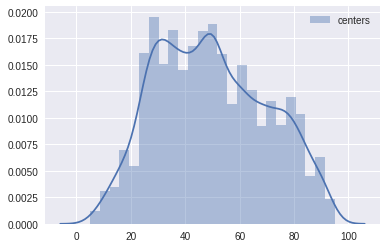

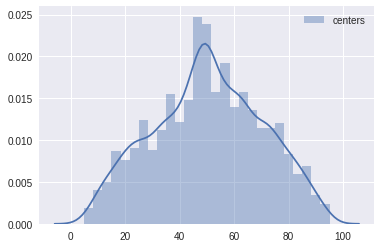

In [112]:
analyze_df(mydf[mydf['sequence'].str[:20].str.upper().str.count('U')<10]
           , fasta_phast20, average=False,walk_stems=True)


In [11]:


print len(stemsdic_list), len(stemsdic_list_shuff)
print (len([s for s in filter_stemsd_list(stemsdic_list,20,7) if len(s)>0]),
       len([s for s in filter_stemsd_list(stemsdic_list_shuff,20,7) if len(s)>0])
      )

NameError: global name 'average_basepair_prob_seqs' is not defined

In [167]:
filter_stemsd_list(stemsdic_list,10,7)

[{},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {'3-13,23-31': (10, 10)},
 {},
 {},
 {},
 {},
 {'33-41,46-53': (9, 5)},
 {'56-66,75-85': (11, 9)},
 {},
 {'1-13,22-35': (13, 9)},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {'22-32,39-48': (11, 7)},
 {'27-34,39-47': (8, 5)},
 {},
 {},
 {},
 {},
 {},
 {},
 {'10-20,24-35': (11, 4)},
 {'13-28,35-49': (15, 7)},
 {},
 {'77-84,90-99': (10, 6)},
 {},
 {},
 {},
 {},
 {'64-78,84-100': (17, 6)},
 {},
 {},
 {'75-81,87-93': (7, 6)},
 {},
 {'47-53,60-66': (7, 7)},
 {'9-17,24-34': (10, 7)},
 {},
 {},
 {'43-54,59-89': (30, 5)},
 {},
 {},
 {},
 {},
 {},
 {},
 {'34-43,48-55': (10, 5)},
 {},
 {},
 {},
 {'22-34,39-51': (13, 5)},
 {},
 {},
 {'67-74,81-88': (8, 7)},
 {},
 {},
 {'1-8,13-19': (7, 5)},
 {},
 {},
 {},
 {'24-33,38-47': (9, 5)},
 {'10-25,31-41': (15, 6)},
 {},
 {},
 {'34-42,47-54': (8, 5)},
 {},
 {},
 {'31-41,47-57': (10, 6)},
 {},
 {},
 {'46-55,64-74': (11, 9)},
 {'14-30,35-92': (57, 5), '53-65,72-82': (13, 7)},

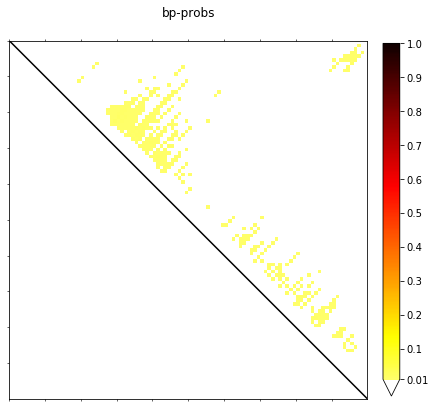

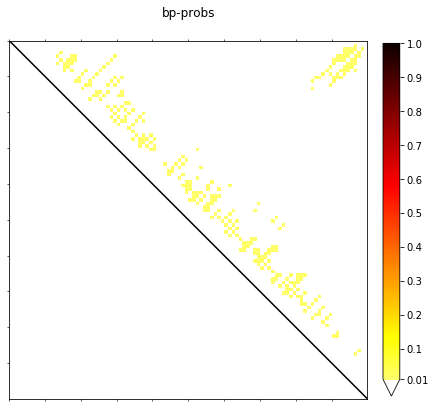

In [8]:
analyze_average_dps('/home/milad/1workspace/GalaxyGraphClust/Staufen/commonfold/stau-phastcons0.2-mergedoverlaps-Galaxy1-[Extract_Genomic_DNA_on_data_1].fasta')
<
analyze_average_dps('/home/milad/1workspace/GalaxyGraphClust/Staufen/commonfold/stau-phastcons0.2-mergedoverlaps-Galaxy1-[Extract_Genomic_DNA_on_data_1].fasta',shuffle=True)

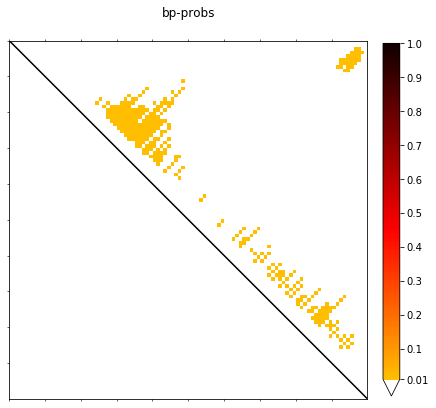

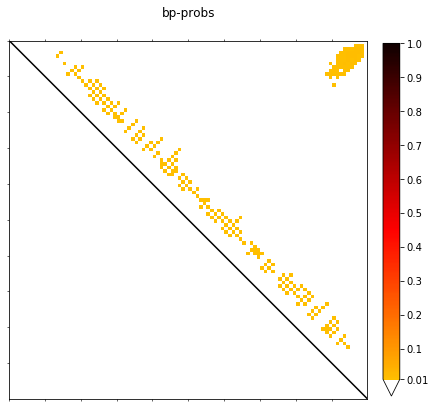

In [20]:
analyze_average_dps('/home/milad/1workspace/GalaxyGraphClust/Staufen/commonfold/stau-mergedoverlap-Galaxy1-[Extract_Genomic_DNA_on_data_1].fasta')
analyze_average_dps('/home/milad/1workspace/GalaxyGraphClust/Staufen/commonfold/stau-mergedoverlap-Galaxy1-[Extract_Genomic_DNA_on_data_1].fasta',shuffle=True)


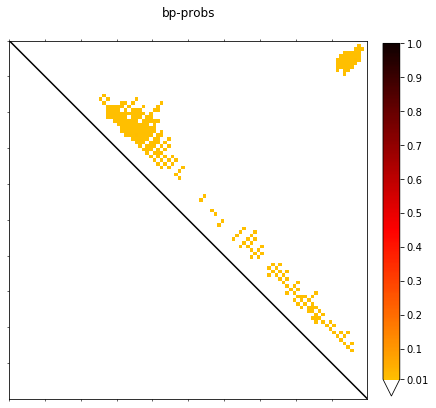

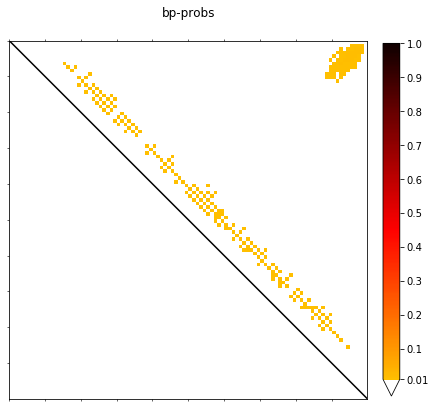

In [21]:
analyze_average_dps('/home/milad/1workspace/GalaxyGraphClust/Staufen/commonfold/Staufen-ALL11k-Galaxy8-[Extract_Genomic_DNA_on_data_3_and_data_7].fasta')
analyze_average_dps('/home/milad/1workspace/GalaxyGraphClust/Staufen/commonfold/Staufen-ALL11k-Galaxy8-[Extract_Genomic_DNA_on_data_3_and_data_7].fasta',shuffle=True)


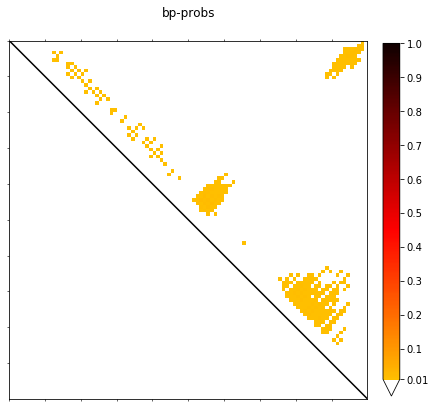

In [22]:
analyze_average_dps('/home/milad/1workspace/GalaxyGraphClust/Staufen/commonfold/Stau-merged-peakcentered-Galaxy2-[Extract_Genomic_DNA_on_data_1].fasta')


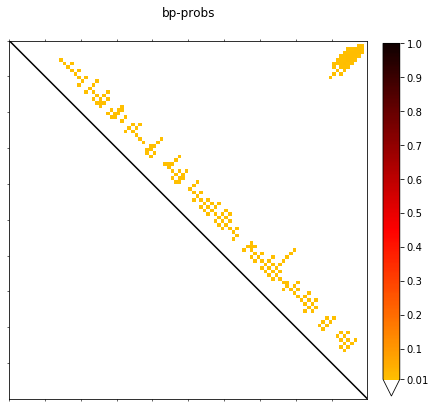

In [23]:
analyze_average_dps('/home/milad/1workspace/GalaxyGraphClust/Staufen/commonfold/Stau-merged-peakcentered-Galaxy2-[Extract_Genomic_DNA_on_data_1].fasta',shuffle=True)


In [83]:
from altschulEriksonDinuclShuffle import dinuclShuffle
dinuclShuffle('CCTGACGTCAGCAGACCGAGACCAGTCCCAGTTCCAGGGGGAGGCCTGCAGGCCCCTGGCCCCTTCCACCACCTCTGCCCTCCGTCTGCAGACCTCGTCC'.replace('T','U'))

'CCGCGGAGCCUCCAGGCACCAGUGGGUCCACUUGUGUGCAGAGACCCCACUGGCCCCCCCCUCUUCCCCAGAGGUCUCUCCAGCAGACUCCGGACUCCGC'

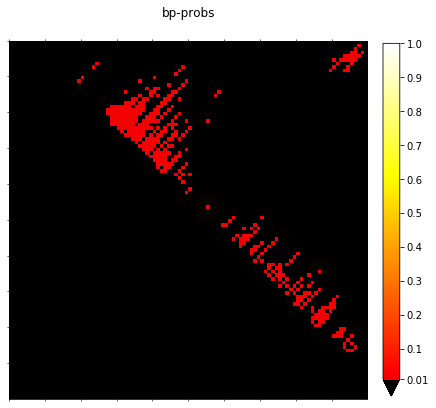

In [49]:
plot_heat_maps(None, average_basepair_prob_seqs(read_seqs[:]), filename='/tmp/test.heatmap', what='basepairs',
                   inverse=False, interactive=False, gene_loc=None)


In [45]:
read_seqs[:10]

['ACCCCTTTCCACCTTTTGTATTTAATTTTAAAGTCAGTGTACTGCAAGGAAGCTGGATGCAAGATAGATACTATATTAAACTGTACTGTTATTTAAGATG',
 'TCTATACAAAACTGTGCTGTGACCTTGCGGTAGGCCTGGATCTGGCAAAGAGAATACAAATGAAACCCCTTCTTTCTCTTTCCGTCCAACAACTCTGTAG',
 'TTTTAATCTCACTTTGGGTTTCCTTGTGAAGTTGGAGGGAAGTTTATAATAGCCTAACACTACCCCACCCCCAACTAGGAGGAACCTCTGTTTTCAAGAG',
 'ATTCCAACTTGGACGCGTTACCATGAGAGCATATCCTATCCAACCGTACTAACGTGGACACCCTACACCTCCCCTCAGAACTTCAAAAGGGCAAGATCTT',
 'TTTTCAGCGACAAGGACCCAGGTCTTCCTGCTGCTGCCAGGGAGAGCAGGGACAGTGCCGCGTGCGAGATGAGCTCGAACACTGCCCGCCTTACTGCCGC',
 'TCTTTGCGGTTGTTCTGTGTGCATGGATTCCACACCTCTGCCGTAGGTAGATCCGTCAGCGGGCATTATTACCGTGTCTTGTAAAGGGTCGGTTTTGTTA',
 'TTTTAACGAAGGGAAAAACAACAGCAATAACATTCATATCTCTGGAGCAGCTAACTCATACACGTAATGTCTGCTTTTCGTACAGAACTAGCCAATGTAA',
 'CGTTCTCGCTTTAAGTCAGGAGTCACAAATGACTTTTTTTTTTCAATTAAGGAAAAAGCTCCATCTCTACCTTTAACATCACCCAGACCCCCGCCCCTGC',
 'ttatCCCTTTAATTAAAGGGAGCAAAGGGGCGTTCCACATGGACAGAGGCTTGGACCGAGGCCTGGTCACAGCAGCGAGCATCCAGGGTTTGCAGGGACG',
 'TTTCCTTGATTTCTCAGTAGGTGCTAGAATCCAGTTCACACCCTTCACTGTGC